In [2]:
import pandas as pd
import numpy as np
import sqlite3, os
from huggingface_hub import login, logout
from datasets import load_dataset
from nltk.corpus import stopwords
import warnings
warnings.filterwarnings('ignore')
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from util.util_data import special_encode, makeRegex, splitData
from util.util_kwrds import class_keywords, extract_keywords
import torch
import logging
logging.getLogger("pytorch_pretrained_bert.tokenization").setLevel(logging.ERROR)

# **1. Clinical Trial Announcements**

In [3]:
engine = sqlite3.connect('./src/data.db')
OUT = 'out'
catalyst = pd.read_sql('SELECT * FROM catalysts', engine)
catalyst.head()

,ticker,disease,stage,date,catalyst
0,SPPI,Non-Hodgkin’s lymphoma,Approved,2009-09-04 00:00:00,"Approved September 4, 2009."
1,JAZZ,Fibromyalgia,CRL,2010-10-11 00:00:00,"CRL received October 11, 2010."
2,ASRT,Postherpetic neuralgia - shingles,Approved,2011-01-28 00:00:00,"Approved January 28, 2011."
3,ASRT,Colorectal cancer,Approved,2011-04-29 00:00:00,"Approved April 29, 2011."
4,SPPI,Colorectal cancer,Approved,2011-04-29 00:00:00,"Approved April 29, 2011."


<Axes: ylabel='stage'>

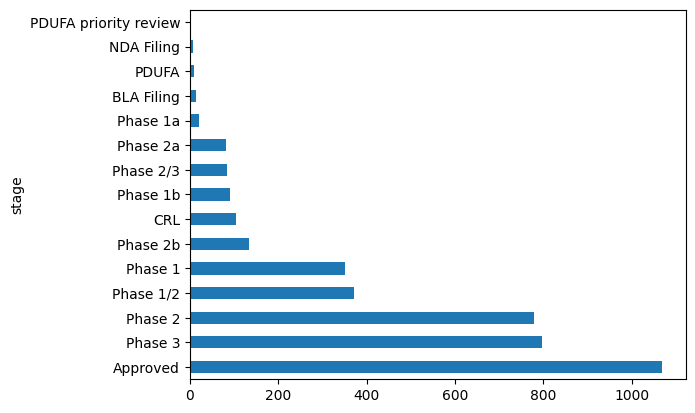

In [4]:
catalyst['stage'].value_counts().plot(kind='barh')

## **1.1 Initial Rule-Based Labeling**

In [5]:
dove = makeRegex(["approv", "meet", "show", "reach"])
hawk = makeRegex(["halt", "fail", "no diff", "stop"]) +\
    makeRegex(dove, neg=True)
labs_init = catalyst['catalyst'].apply(special_encode,
                                       bull_words=dove,
                                       bear_words=hawk)

In [6]:
labs_init.value_counts()

catalyst
 0    2087
 1    1786
-1      38
Name: count, dtype: int64

<Axes: ylabel='catalyst'>

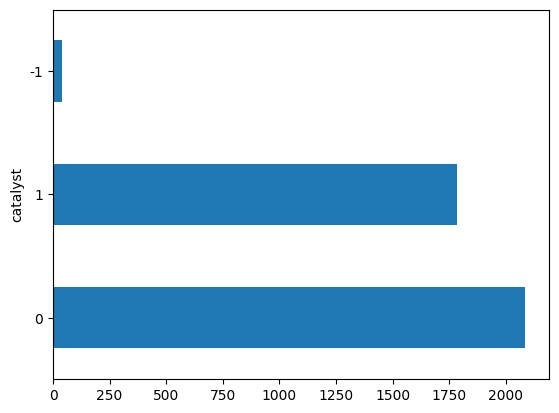

In [7]:
# 1: Dovish; 0: Neutral; -1: Hawkish
labs_init.value_counts().plot(kind='barh')

## **1.2 Keyword Generation with BioBERT**

In [8]:
#  NOTE: change if needed
#  "dmis-lab/TinySapBERT-from-TinyPubMedBERT-v1.0" BioBERT
#  "roberta-large-mnli" RoBERTa Large
filtered_words = [i for i in stopwords.words('english') if i not in  ["no", "not"]]
model = SentenceTransformer('dmis-lab/TinySapBERT-from-TinyPubMedBERT-v1.0') # fine-tuned bioBERT
key_words = catalyst['catalyst'].apply(extract_keywords, stop_words=filtered_words, model=model) # generate keywords
tokenizer = AutoTokenizer.from_pretrained("dmis-lab/TinySapBERT-from-TinyPubMedBERT-v1.0") # tokenizer
model = AutoModelForSequenceClassification.from_pretrained("dmis-lab/TinySapBERT-from-TinyPubMedBERT-v1.0") # classifier
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer, device=torch.device('cpu'), framework='pt', truncation=True)

No sentence-transformers model found with name /Users/MicheleOrlandi/.cache/torch/sentence_transformers/dmis-lab_TinySapBERT-from-TinyPubMedBERT-v1.0. Creating a new one with MEAN pooling.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at dmis-lab/TinySapBERT-from-TinyPubMedBERT-v1.0 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
class_kwrds = class_keywords(classifier=classifier, kwrds=key_words) # sentiment analysis on generated keywords

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [10]:
class_kwrds.head()

,label,score,keywords
4768,LABEL_0,0.617053,2020 62 reduction
18639,LABEL_0,0.616820,878 875 mutations
6564,LABEL_0,0.615535,2021 not demonstrate
497,LABEL_0,0.614144,2016 not demonstrate
17612,LABEL_0,0.613474,24 2024 additionally


In [11]:
# compared outputs from BioBERT or RoBERTa to improve our keyword selection to build ground truth labels
dove_bert = [
    "preserv", "eval", "improv", "demonstra",\
        "present", "observ", "achiev", "attain",\
            "favor", "toler", "treat", "reduc"] # manually inspected better labels
hawk_bert = [
    "discontinu", "terminat", "pause", "insuffic"
]
hawk_bert = makeRegex(dove_bert, neg=True) + makeRegex(hawk_bert) + hawk
dove_bert = makeRegex(dove_bert) + dove
labs_new = catalyst['catalyst'].apply(special_encode,
                                        bull_words=dove_bert,
                                        bear_words=hawk_bert)

In [12]:
labs_new.value_counts()

catalyst
 1    2814
 0     966
-1     131
Name: count, dtype: int64

<Axes: ylabel='catalyst'>

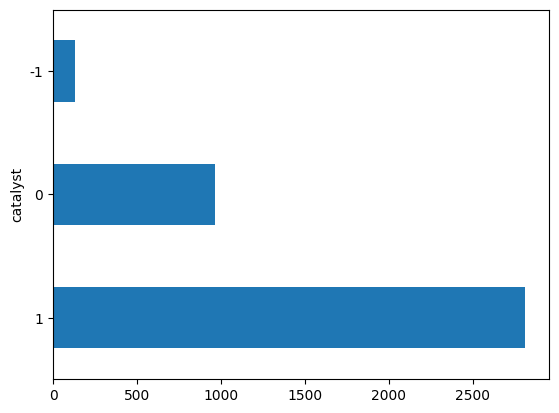

In [13]:
labs_new.value_counts().plot(kind='barh')

# **2. Dataset Creation**

In [14]:
# add better labels to dataframe
catalyst['label'] = labs_new
catalyst.head()

,ticker,disease,stage,date,catalyst,label
0,SPPI,Non-Hodgkin’s lymphoma,Approved,2009-09-04 00:00:00,"Approved September 4, 2009.",1
1,JAZZ,Fibromyalgia,CRL,2010-10-11 00:00:00,"CRL received October 11, 2010.",0
2,ASRT,Postherpetic neuralgia - shingles,Approved,2011-01-28 00:00:00,"Approved January 28, 2011.",1
3,ASRT,Colorectal cancer,Approved,2011-04-29 00:00:00,"Approved April 29, 2011.",1
4,SPPI,Colorectal cancer,Approved,2011-04-29 00:00:00,"Approved April 29, 2011.",1


In [19]:
train, test = splitData(df=catalyst, train_size=0.8) # randomly split data

In [23]:
train.head()

,ticker,disease,stage,date,catalyst,label
892,AZN,Heart failure,Approved,2020-05-05 00:00:00,"FDA Approval announced May 5, 2020.",1
3719,BMY,Stage IIA to IIIB non-small cell lung cancer (...,Phase 3,2023-10-21 00:00:00,Phase 3 data presented at ESMO reported that N...,1
2280,FOLD,Pompe disease,Phase 1/2,2022-10-12 00:00:00,Phase 1/2 trial long term followup data report...,1
1130,LLY,Type 2 Diabetes,Phase 3,2020-12-09 00:00:00,"Phase 3 data released December 9, 2020 - signi...",1
130,KPTI,Relapsed/Refractory Acute Myeloid Leukemia (AML),Phase 2,2017-03-02 00:00:00,Data Safety Monitoring Board (DSMB) noted Marc...,1


In [24]:
if OUT not in os.listdir(os.getcwd()):
    os.mkdir(OUT)
train.to_csv(f"{OUT}/train.csv", index=0)
test.to_csv(f"{OUT}/test.csv", index=0)
catalyst.to_csv(f"{OUT}/catalyst.csv", index=0)

In [26]:
login()

In [29]:
dataset = load_dataset("quant-chef/BioPharmaCatalysts")

Extracting data files: 100%|██████████| 2/2 [00:00<00:00, 509.82it/s]
Generating train split: 3128 examples [00:00, 69540.47 examples/s]
Generating test split: 783 examples [00:00, 91386.04 examples/s]


In [32]:
dataset

DatasetDict({
    train: Dataset({
        features: ['ticker', 'disease', 'stage', 'date', 'catalyst', 'label'],
        num_rows: 3128
    })
    test: Dataset({
        features: ['ticker', 'disease', 'stage', 'date', 'catalyst', 'label'],
        num_rows: 783
    })
})

In [33]:
logout()


Successfully logged out.
